In [1]:
import sys
import argparse
import os
import numpy as np
from skimage.util import view_as_windows
from utilities.config_handler import get_config
from utilities.learning import split_train_validation, train_model, predict_ae_error_vectors
from utilities.detection import detect_reconstruction_anomalies_median,plot_spectogram_anomalies
from utilities.preprocessing import  add_noise,load_fft_test_data ,load_fft_train_data,  reshape_to_blocks,persist_object\
    ,load_object,persist_val_stat, load_val_stat ,get_xhdr_sample_rate
import matplotlib.pyplot as plt
from sklearn import mixture
from scipy.stats import entropy
%matplotlib inline

Using TensorFlow backend.


In [2]:
parser = argparse.ArgumentParser()
parser.prog = 'Spectrum Anomaly Detection'
parser.description = 'Use this command parser for training or testing the anomaly detector'
parser.add_argument('-m', '--mode', help='train or test mode', choices=['train', 'test'])
parser.add_argument('-d', '--data-dir', help='I/Q recording directory')
parser.add_argument('-w', '--weights-path', help='path for trained weights')


sys.argv = "-m test -d iq_data/CELL/anomal/CELL/CELL_SWP_18MHz_50us_10dB -w model/baseline_gmm".split()
namespace = parser.parse_args(sys.argv)
if not namespace.data_dir and namespace.mode == 'train':
    parser.error('the -d arg must be present when mode is train')
if not namespace.weights_path and namespace.mode == 'train':
    parser.error('the -w arg must be present when mode is train')

if not namespace.data_dir and namespace.mode == 'test':
    parser.error('the -d arg must be present when mode is test')
if not namespace.weights_path and namespace.mode == 'test':
    parser.error('the -w arg must be present when mode is test')

# Hyper parameters

In [3]:
conf=get_config()
gpus = conf['gpus']
lr=conf['learning']['ae']['lr']
validation_split = conf['learning']['ae']['validation_split']
train_params = conf['learning']['ae']
rbw_set = conf['preprocessing']['ae']['rbw_set']
feature_names = conf['preprocessing']['ae']['feature_names']
train = namespace.mode == 'train'

data_dir = namespace.data_dir

atom_height = 3
num_clusters = 100
f_s = get_xhdr_sample_rate(data_dir)
test_window_time = 10e-6
cv_types = ['diag']

In [4]:
def split_spectogram_to_atoms(spectogram,atom_height,stride=1):
    window_shape = (atom_height , spectogram.shape[1])
    return view_as_windows(spectogram,window_shape,step=stride).reshape(-1,*window_shape)

In [5]:
def split_spectogram_by_fraction(spectogram,frac):
    return spectogram[:int(frac*len(spectogram))]

In [6]:
def fit_gmm(data,num_clusters,cv_types):
    lowest_bic = np.infty
    bic = []
    best_component=''
    best_cv=''
    best_gmm={}
    n_components_range = np.arange(2, num_clusters,20) # specifying maximum number of clusters
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a mixture of Gaussians with EM
            gmm = mixture.GaussianMixture(n_components=num_clusters, covariance_type=cv_type,verbose=2)
            gmm.fit(data)
            bic.append(gmm.bic(data))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_component = n_components
                best_cv = cv_type
                best_gmm = gmm
                print(best_cv)
                print(lowest_bic)
    print("best n_component {}".format(best_component))
    print("best gmm type {}".format(best_cv))
    return best_gmm


In [8]:
assert len(data_dir) != 0
dataset_name = str.split(data_dir, '/')[-2]
if train:
    for rbw in rbw_set:
        weights_dir = "_".join((dataset_name, str(rbw)))
        weights_path = os.path.join(namespace.weights_path, weights_dir)
        fft_train = load_fft_train_data(data_dir, rbw, weights_path)
        fft_train = split_spectogram_by_fraction(fft_train,0.05)
        print(len(fft_train))
        atom_fft_train = split_spectogram_to_atoms(fft_train,atom_height)
        atom_fft_train = atom_fft_train.reshape(len(atom_fft_train),-1)
        gmm = mixture.GaussianMixture(n_components=num_clusters, covariance_type='diag',verbose=2)
        gmm.fit(atom_fft_train)
#         gmm = fit_gmm(atom_fft_train,num_clusters,cv_types)
        train_log_likelihood = gmm.score_samples(atom_fft_train)
        window_shape = (atom_height , atom_fft_train.shape[1] // atom_height)
        persist_object(gmm,os.path.join(weights_path,'gmm.pkl'))
        
else:
    
    for rbw in rbw_set:
        weights_dir = "_".join((dataset_name, str(rbw)))
        weights_load_path = os.path.join(namespace.weights_path, weights_dir)
        freqs_test, time_test, fft_test = load_fft_test_data(data_dir, rbw, weights_load_path)
        
        fft_test = split_spectogram_by_fraction(fft_test,0.05)
        atom_fft_test = split_spectogram_to_atoms(fft_test,atom_height)
        flatten_atom_fft_test = atom_fft_test.reshape(len(atom_fft_test),-1)
        gmm = load_object(os.path.join(weights_load_path,'gmm.pkl'))
        window_shape = (atom_height , atom_fft_test.shape[1] // atom_height)
        test_log_likelihood = gmm.score_samples(flatten_atom_fft_test)

In [11]:
window_shape = (atom_height , atom_fft_test.shape[1] // atom_height)

In [12]:
score_spectogram = np.ones_like(atom_fft_test)

In [13]:
for (i,score) in enumerate(test_log_likelihood):
    sample_score_windows = np.ones((window_shape))*score
    score_spectogram[i*atom_height : (i+1)*atom_height ,:,:] = sample_score_windows

In [14]:
score_spectogram = score_spectogram.reshape((len(score_spectogram),-1))

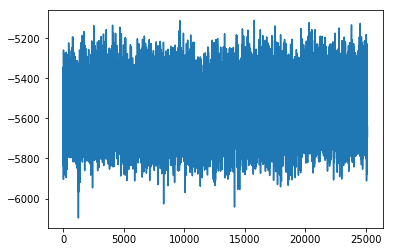

In [17]:
plt.plot(test_log_likelihood)

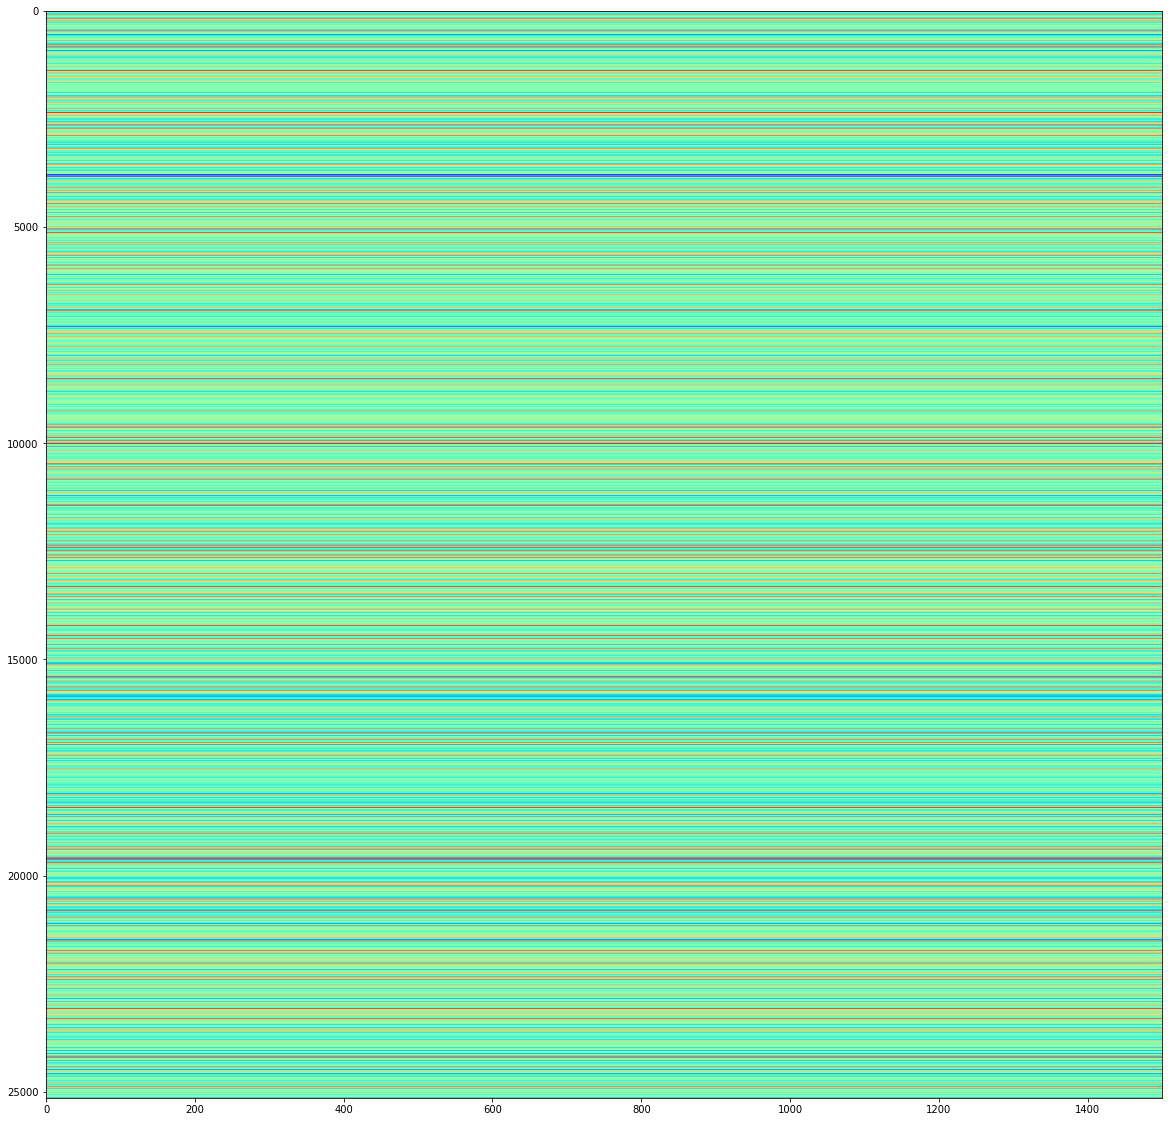

In [19]:
fig = plt.figure(figsize=(20, 20))
plt.imshow(score_spectogram,aspect='auto',cmap='rainbow')

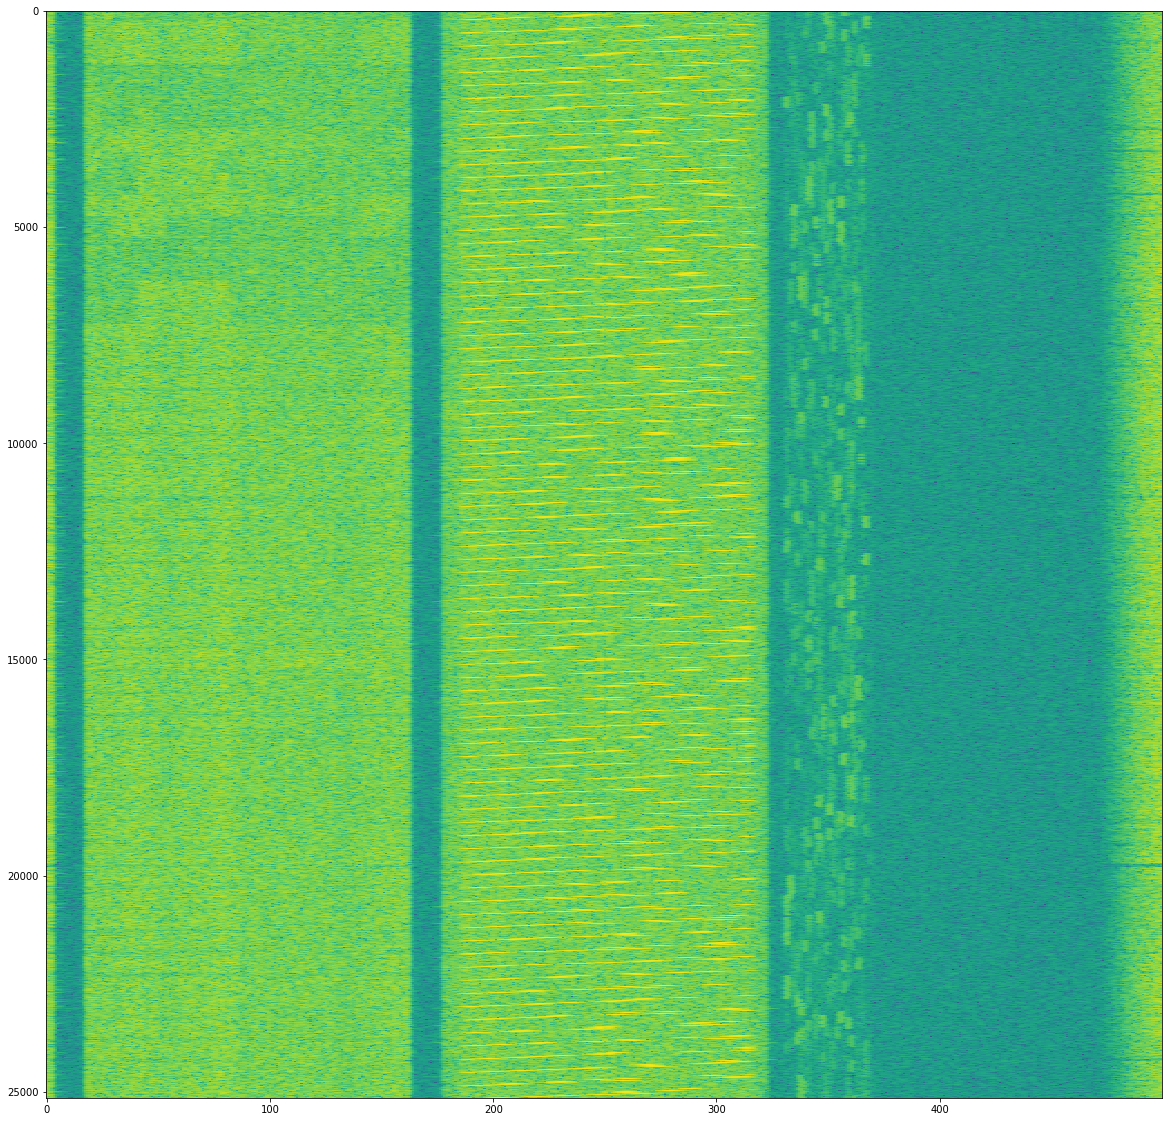

In [20]:
fig = plt.figure(figsize=(20, 20))
plt.imshow(fft_test,aspect='auto')